In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

%matplotlib inline

DATA_DIR='/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need'
train = os.listdir(os.path.join(DATA_DIR,'train'))
test = os.listdir(os.path.join(DATA_DIR,'test'))
val=os.listdir(os.path.join(DATA_DIR,'valid'))
print(f'Train - {train}')
print(f'Test - {test}')
print(f'Val - {val}')

IMG_SIZE = 48
EMOTIONS = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral', 'Disgusted', 'Fear', 'Sleepy', 'Contempt']  # update based on your labels
emotion_to_idx = {e: i for i, e in enumerate(EMOTIONS)}
idx_to_emotion = {i: e for i, e in enumerate(EMOTIONS)} # Add mapping from index to emotion

def load_data(folder_path):
    image_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    images = []
    labels = []

    # Get list of label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for label_fname in label_files:
        image_fname = label_fname.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_fname)
        label_path = os.path.join(label_dir, label_fname)

        # Check if the corresponding image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found for label file {label_path}. Skipping.")
            continue

        # Load image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image file {image_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48×48
        images.append(img)

        # Load and parse label from YOLO format
        with open(label_path, 'r') as f:
            label_content = f.read().strip()
            # Assuming the first number in the line is the class ID
            try:
                class_id = int(label_content.split()[0])
                labels.append(class_id)
            except (ValueError, IndexError):
                print(f"Warning: Could not parse label from file {label_path}. Content: '{label_content}'. Skipping.")
                images.pop() # Remove the image if label parsing fails
                continue


    images = np.array(images)
    labels = np.array(labels)
    return images, labels
     

# Load full data from train folder
images, labels = load_data(os.path.join(DATA_DIR, 'test'))

# Normalize pixel values to be between 0 and 1
images = images / 255.0


# Reduce dataset size
n_train = 50000
n_test = 30000

train_images = images[:]
train_labels = labels[:]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add grayscale channel dimension: (N, 48, 48, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Final checks
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

2025-08-27 12:35:06.547965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756298106.740623      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756298106.798305      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train - ['labels', 'images']
Test - ['labels', 'images']
Val - ['labels', 'images']
Train images shape: (1700, 48, 48, 1)
Test images shape: (1700, 48, 48, 1)
Train labels shape: (1700, 9)
Test labels shape: (1700, 9)


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize
import numpy as np

# ----------------- Data Augmentation -----------------
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# ----------------- Preprocess images -----------------
def prepare_for_vgg(images):
    # Resize to (224,224) and convert grayscale to RGB
    resized = np.array([resize(img, (224,224)).numpy() for img in images])
    if resized.shape[-1] == 1:  # grayscale to RGB
        resized = np.repeat(resized, 3, axis=-1)
    return resized

train_images_vgg = prepare_for_vgg(train_images)
test_images_vgg = prepare_for_vgg(test_images)

print("Train shape:", train_images_vgg.shape)
print("Test shape:", test_images_vgg.shape)

# ----------------- Callbacks -----------------
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    verbose=1,
    factor=0.1,
    min_lr=1e-5
)

# ----------------- Build VGG16 Model -----------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze VGG16 backbone

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(EMOTIONS), activation='softmax')  # match number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ----------------- Training -----------------
batch_size = 32
epochs = 70  # transfer learning usually converges faster

history = model.fit(
    datagen.flow(train_images_vgg, train_labels_categorical, batch_size=batch_size),
    validation_data=(test_images_vgg, test_labels_categorical),
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)

I0000 00:00:1756298157.835040      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Train shape: (1700, 224, 224, 3)
Test shape: (1700, 224, 224, 3)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,110,985 (57.64 MB)

 Trainable params: 396,297 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70


I0000 00:00:1756298168.583080      79 service.cc:148] XLA service 0x7b252c00fcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756298168.584041      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756298169.090127      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/54 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.0938 - loss: 2.1501  

I0000 00:00:1756298177.926720      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 527ms/step - accuracy: 0.2231 - loss: 2.0371 - val_accuracy: 0.2688 - val_loss: 1.9365 - learning_rate: 0.0010
Epoch 2/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - accuracy: 0.2565 - loss: 1.9480 - val_accuracy: 0.2524 - val_loss: 1.8828 - learning_rate: 0.0010
Epoch 3/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - accuracy: 0.2920 - loss: 1.8564 - val_accuracy: 0.3135 - val_loss: 1.8181 - learning_rate: 0.0010
Epoch 4/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - accuracy: 0.3093 - loss: 1.8441 - val_accuracy: 0.3176 - val_loss: 1.8157 - learning_rate: 0.0010
Epoch 5/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.3082 - loss: 1.8173 - val_accuracy: 0.2924 - val_loss: 1.8009 - learning_rate: 0.0010
Epoch 6/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 404ms/step - accuracy: 0.3216 - loss: 1.7745 - val_accuracy: 0.3288 - val_loss: 1.7688 - learning_rate: 0.0010
Epoch 7/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 408ms/step - accuracy: 0.3460 - loss: 1.7399 - val_

54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step

Classification Report:

              precision    recall  f1-score   support

       Happy       0.58      0.56      0.57       297
         Sad       0.50      0.37      0.42        68
       Angry       0.65      0.31      0.42        98
   Surprised       0.49      0.65      0.56       144
     Neutral       0.75      0.75      0.75       407
   Disgusted       0.54      0.38      0.44       136
        Fear       0.53      0.65      0.58       298
      Sleepy       0.88      0.64      0.74        33
    Contempt       0.62      0.66      0.64       219

    accuracy                           0.61      1700
   macro avg       0.62      0.55      0.57      1700
weighted avg       0.61      0.61      0.60      1700



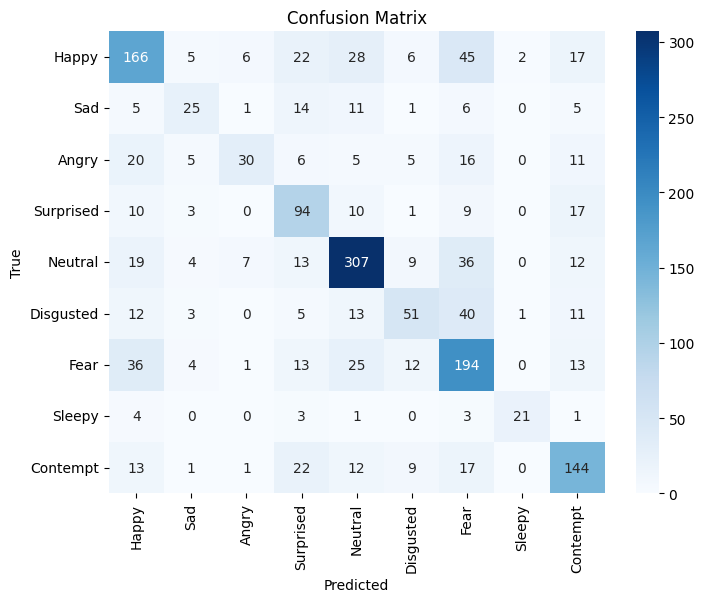

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------- Predictions -----------------
y_pred_probs = model.predict(test_images_vgg)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

# ----------------- Classification Report -----------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS))

# ----------------- Confusion Matrix -----------------
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()